## Test01_2 MNE

เปลี่ยนการเขียน csp และก่อนเข้า csp ลองแยก split

- Preprocessing
- Feature Extraction
- Classification

link to dataset: https://ieee-dataport.org/documents/upper-limb-rehabilitation-motor-imagery-eeg-signals - 1398.18 Baht

- EEG Placement 10-20 electrode system

- Notch filter 50 hz applied

- 8th order chebyshev bandpass filter 0.01 hz - 200hz appiled

- Sampling rate 500 Hz

**Planning: Use only 1 subjects for testing code.**

1. Read all .set files, find only S1R1 - S1R10
2. merge the files in to 1 set
3. Preprocessing (Fliter + Baseline correction + Epoching)
4. Epoching only Flexion and Extension 

In [47]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import re
import mne
from mne import concatenate_epochs
from mne.preprocessing import ICA
from mne_icalabel import label_components
import onnxruntime
import torch
import seaborn as sns
import pandas as pd
from mne.decoding import CSP
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    roc_auc_score,
    RocCurveDisplay
)
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from IPython.display import display

#### Step 1: READ Dataset 

- read only S1R1 - S1R10
- rename label from 'elbow flexion' to 'S1R1_elbow flexion' for easy to concat

In [48]:
DataFolder = 'G:\\KMUTT\\Y3_Term2\\Studio_OpenTopic\\StudioV_opentopics\\Dataset_used'

In [49]:
subjects = [1]

# Label 6 classes
label_map = {
    'forearm supination': 0,
    'forearm pronation': 1,
    'shoulder adduction': 2,
    'shoulder abduction': 3,
    'elbow extension': 4,
    'elbow flexion': 5
}

# Helper สำหรับเรียง Run
def extract_run_num(name):
    match = re.search(r'R(\d+)', name)
    return int(match.group(1)) if match else 0

# เตรียมเก็บข้อมูล
EpochList = []
y_all = []

# Load ทุก Subject และ Run
for s in subjects:
    for file_name in sorted(os.listdir(DataFolder), key=extract_run_num):
        if file_name.startswith(f"S{s}R") and file_name.endswith(".set"):
            path = os.path.join(DataFolder, file_name)
            print(f"Reading {file_name}...")

            try:
                # Load .set
                epochs = mne.io.read_epochs_eeglab(path, verbose='ERROR')

                #  สร้าง mapping ชื่อ event เดิม (เช่น S1R1_elbow flexion)
                id_to_name = {v: k for k, v in epochs.event_id.items()}

                #  รีแมพทุก event ใหม่ให้ match กับ label_map
                new_events = []
                selected_labels = []

                for i, (onset, _, eid) in enumerate(epochs.events):
                    event_name = id_to_name[eid].split('_')[-1]
                    if event_name in label_map:
                        new_eid = label_map[event_name]
                        new_events.append([onset, 0, new_eid])
                        selected_labels.append(new_eid)

                if new_events:
                    # 📎 สร้าง Epochs ใหม่ด้วย event ที่รีแมพแล้ว
                    new_events = np.array(new_events)
                    epochs.events = new_events
                    epochs.event_id = label_map.copy()

                    # เฉพาะ epoch ที่เราใช้จริง
                    EpochList.append(epochs)
                    y_all.extend(selected_labels)

            except Exception as e:
                print(f"❌ Failed to load {file_name}: {e}")

# รวมเป็นก้อนเดียวแบบปลอดภัย
combined_epochs = concatenate_epochs(EpochList)
X_all = combined_epochs.get_data()
y_all = np.array(y_all)

# สรุป
print("\n รวมข้อมูลเสร็จแล้ว:")
print(" X shape (n_epochs, n_channels, n_times): ", X_all.shape)         # (n_epochs, n_channels, n_times)
print(" y shape (n_epochs):", y_all.shape)         # (n_epochs,)
print(" Label counts (0–5):", np.bincount(y_all))


Reading S1R1.set...
Reading S1R2.set...
Reading S1R3.set...
Reading S1R4.set...
Reading S1R5.set...
Reading S1R6.set...
Reading S1R7.set...
Reading S1R8.set...
Reading S1R9.set...
Reading S1R10.set...
Not setting metadata
1800 matching events found
No baseline correction applied

 รวมข้อมูลเสร็จแล้ว:
 X shape (n_epochs, n_channels, n_times):  (1800, 16, 1500)
 y shape (n_epochs): (1800,)
 Label counts (0–5): [300 300 300 300 300 300]


##### Test Combined Epochs

In [50]:
combined_epochs

<EpochsArray | 1800 events (all good), -1 – 1.998 s (baseline off), ~329.6 MiB, data loaded,
 'forearm supination': 300
 'forearm pronation': 300
 'shoulder adduction': 300
 'shoulder abduction': 300
 'elbow extension': 300
 'elbow flexion': 300>

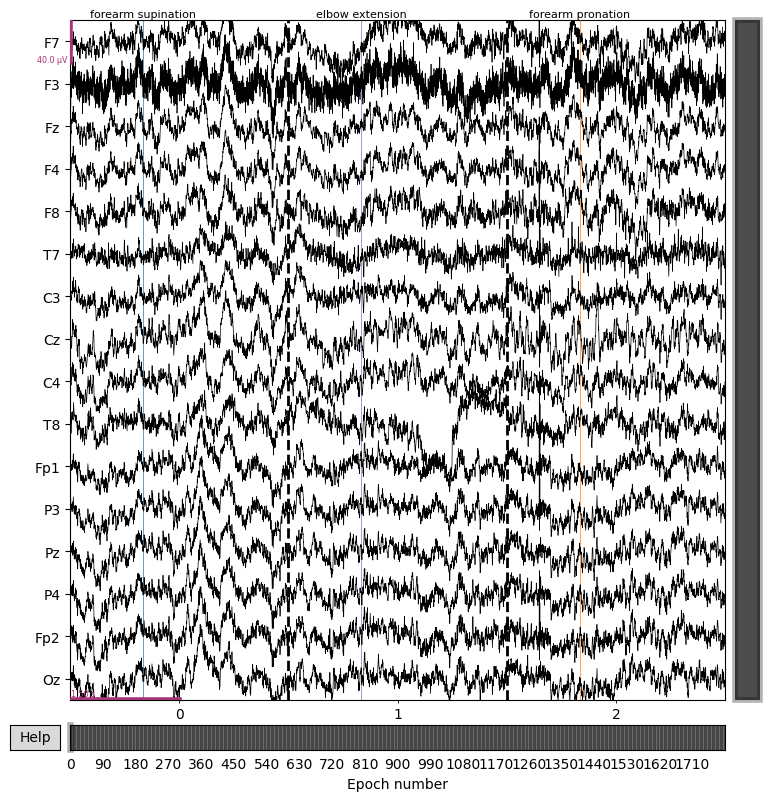

Epoch 0: forearm supination
Epoch 1: elbow extension
Epoch 2: forearm pronation
Epoch 3: shoulder adduction
Epoch 4: shoulder adduction
Epoch 5: shoulder abduction
Epoch 6: forearm pronation
Epoch 7: shoulder adduction
Epoch 8: forearm pronation
Epoch 9: elbow extension
Epoch 10: forearm pronation
Epoch 11: elbow extension
Epoch 12: forearm supination
Epoch 13: elbow extension
Epoch 14: elbow extension
Epoch 15: forearm supination
Epoch 16: forearm pronation
Epoch 17: shoulder adduction
Epoch 18: shoulder abduction
Epoch 19: forearm supination
Epoch 20: forearm pronation
Epoch 21: shoulder adduction
Epoch 22: forearm supination
Epoch 23: shoulder abduction
Epoch 24: elbow extension
Epoch 25: forearm pronation
Epoch 26: forearm supination
Epoch 27: elbow flexion
Epoch 28: shoulder abduction
Epoch 29: forearm supination
Epoch 30: forearm supination
Epoch 31: elbow flexion
Epoch 32: elbow extension
Epoch 33: shoulder abduction
Epoch 34: elbow extension
Epoch 35: shoulder adduction
Epoch 3

In [51]:
#Check Overview and each epoch name
overviewpic = combined_epochs.plot(n_epochs=3,events=True, event_id = True)

# Plot each epoch name
for i in range(len(combined_epochs)):
    event_id = combined_epochs.events[i, 2]
    label = [k for k, v in combined_epochs.event_id.items() if v == event_id]
    print(f"Epoch {i}: {label[0] if label else 'Unknown'}")


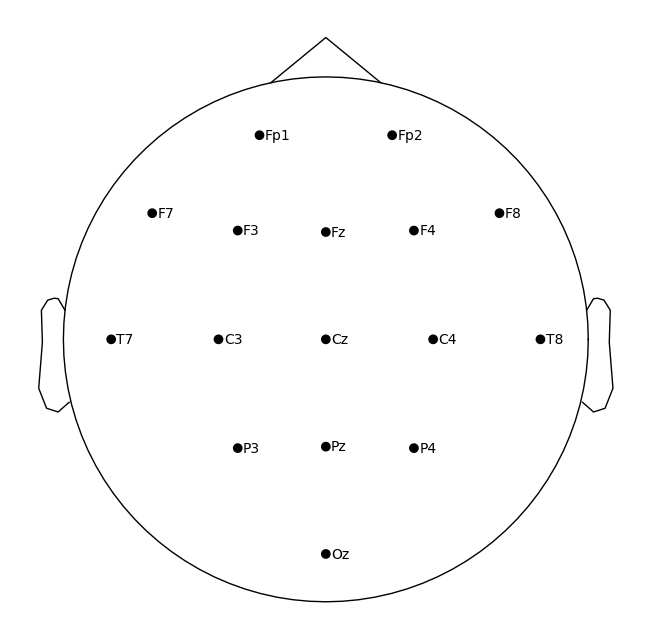

In [52]:
#Check sensor location
SensorPic = combined_epochs.plot_sensors(show_names=True, sphere =0.125) #ยิ่งเพิ่มยิ่งลดขนาด

### Step 2: Bandpass Filter

Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.5s
[Parallel(n_job

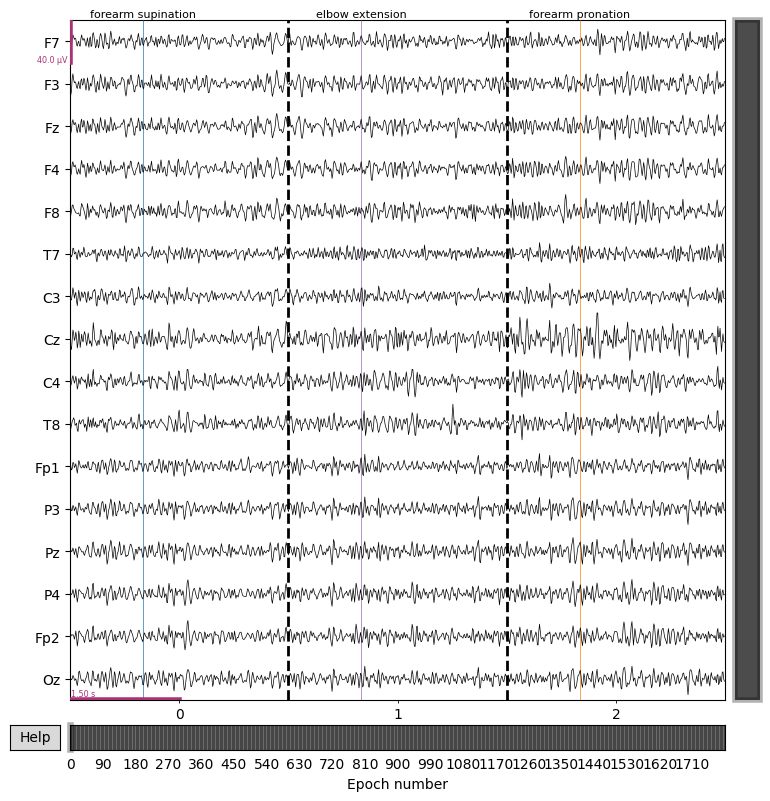

In [53]:
#copy old dataset
copy_combined = combined_epochs.copy()

#Apply bandpass
filtered_epochs = copy_combined.filter(l_freq=8.0, h_freq=30.0)

figfilter = filtered_epochs.plot(n_epochs=3, events=True, event_id=True)

### Check Bandpass

In [54]:
print("High-pass:", filtered_epochs.info['highpass'])
print("Low-pass :", filtered_epochs.info['lowpass'])

High-pass: 8.0
Low-pass : 30.0


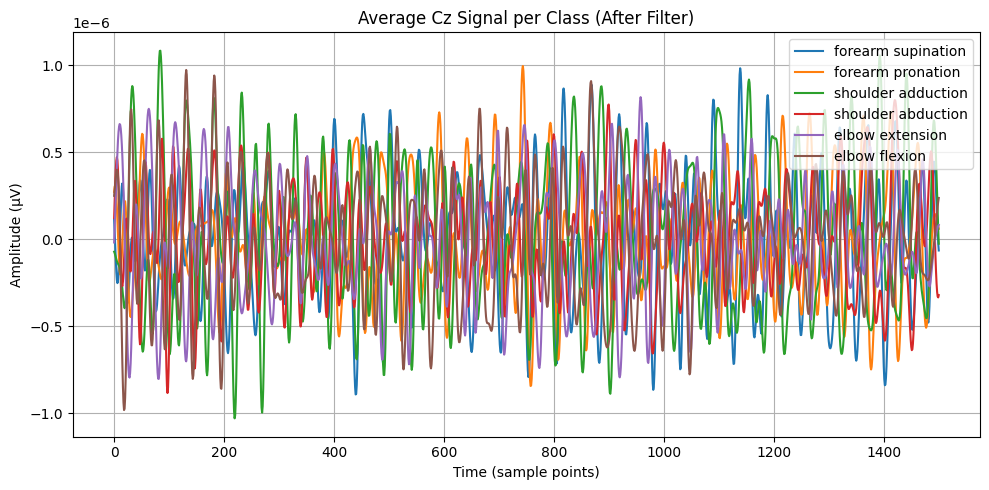

In [55]:
#ดู mean signal (channel เช่น Cz) เปรียบเทียบแต่ละคลาส
cz_idx = filtered_epochs.ch_names.index('Cz')
X_bandpassed = filtered_epochs.get_data()  # เอา data ออกมาจาก filtered_epochs

plt.figure(figsize=(10,5))

for class_id in np.unique(y_all):
    class_name = list(label_map.keys())[class_id]
    mean_signal = X_bandpassed[y_all == class_id, cz_idx, :].mean(axis=0)
    plt.plot(mean_signal, label=class_name)

plt.title("Average Cz Signal per Class (After Filter)")
plt.xlabel("Time (sample points)")
plt.ylabel("Amplitude (μV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [56]:
# #ดูพลังงานรวมของแต่ละ clas
# energy = [np.mean(np.square(filtered_epochs[y_all == i])) for i in range(6)]
# classes = list(label_map.keys())

# plt.bar(classes, energy)
# plt.ylabel("Average Energy")
# plt.title("Signal Energy per Class (8–30 Hz)")
# plt.xticks(rotation=30)
# plt.grid(axis='y')
# plt.tight_layout()
# plt.show()


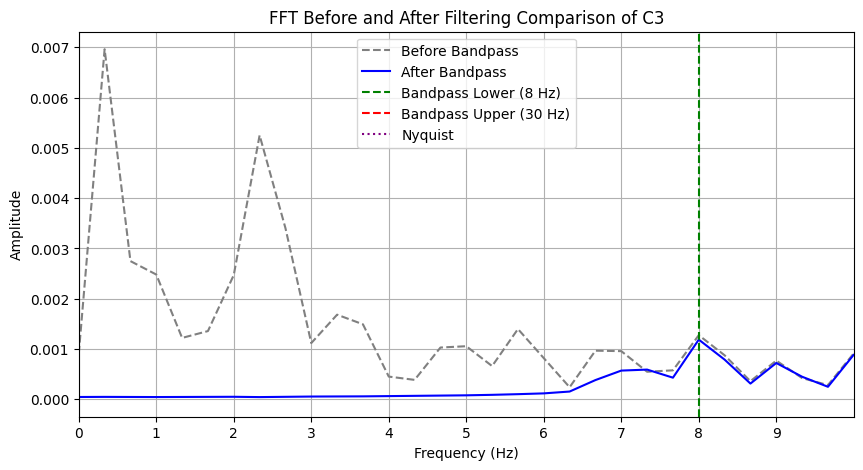

In [57]:
#Plot fft
channel_nam = 'C3'
channel_id = combined_epochs.ch_names.index(channel_nam)  # ก่อน filter
fis = combined_epochs.info['sfreq']

# สัญญาณก่อน filter
signal_before = combined_epochs.get_data()[0, channel_id, :]
# สัญญาณหลัง filter
signal_after = filtered_epochs.get_data()[0, channel_id, :]

# FFT
nu = len(signal_after)
freqs = np.fft.rfftfreq(nu, 1/fis)
fft_before = np.abs(np.fft.rfft(signal_before))
fft_after = np.abs(np.fft.rfft(signal_after))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(freqs, fft_before, label="Before Bandpass", color='gray', linestyle='--')
plt.plot(freqs, fft_after, label="After Bandpass", color='blue')
plt.axvline(8, color='green', linestyle='--', label='Bandpass Lower (8 Hz)')
plt.axvline(30, color='red', linestyle='--', label='Bandpass Upper (30 Hz)')
plt.axvline(fis/2, color='purple', linestyle=':', label='Nyquist')

plt.title(f"FFT Before and After Filtering Comparison of {channel_nam}")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
# plt.xlim(0, fs / 2)
# plt.ylim(0, 0.0015)  
plt.xlim(0,10)
plt.xticks(np.arange(0, 10, 1))  # ticks each 1 Hz
# plt.ylim(0,0.005)
# plt.yticks(np.arange(0, 0.005, 0.001))  # ticks each 1 Hz
plt.show()


### Step 3: Downsampling

In [58]:
downsampled_epochs = filtered_epochs.copy().resample(128)#128 100
downsampled_epochs.info

<Info | 8 non-empty values
 bads: []
 ch_names: F7, F3, Fz, F4, F8, T7, C3, Cz, C4, T8, Fp1, P3, Pz, P4, Fp2, Oz
 chs: 16 EEG
 custom_ref_applied: False
 dig: 19 items (3 Cardinal, 16 EEG)
 highpass: 8.0 Hz
 lowpass: 30.0 Hz
 meas_date: unspecified
 nchan: 16
 projs: []
 sfreq: 128.0 Hz
>